# Country Profiling Using PCA and Clustering

## Introduction

The data from this analysis is from [kaggle Unsupervised Learning on Country Data](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data), which contains socio-economic and health related factors of 167 countries over the world. The goal of the project is to categorise the countries using socio-economic and health factors that determine the overall development of the country.

The variables provided in the dataset include socio-economic factors such as export, import and GDP of a country, as well as heath-related factors such as child mortality rate, life expectancy and health spend % of a country. The data is relatively well formatted and unlablled. Due to the nature of the dataset, the analysis will use a combinatino of **Unsupervised Machine Learning techniques** such as kmeans clustering and **Dimensionality Reduction techniques** such as Principal Component Analysis. We'll also perform outlier analysis and scalling the data to provide a more accurate clustering result.

## Loading data and libraries

The analysis starts with loading data and necessary library.


In [1]:
# Load necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

# set default plot size
plt.rcParams["figure.figsize"] = (15,8)

In [2]:
# Load and preview data 
country = pd.read_csv("/Users/leo/Personal/GitHub/Unsupervised_Learning_Country_Clustering/Country-data.csv")

country.head()
# print(country.shape)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Exploratory Data Analysis

After the data being loaded, we can see that there are a total of 167 countries and 9 features/factors in the dataset. Using `describe()` to provide a descriptive statistics, we can see that some of the variables such as **GDP** and **income** have some extreme values.

In [3]:
# Summary Statistics
country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [4]:
# Check each column for nas
country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

By plotting a spirplot, we can get a better understanding of how the data are distributed. We can also see that some of the variables have strong linear or non-linear correlations between each other. To further explore them, we'll use `corr()` function to generate a correlation matrix.

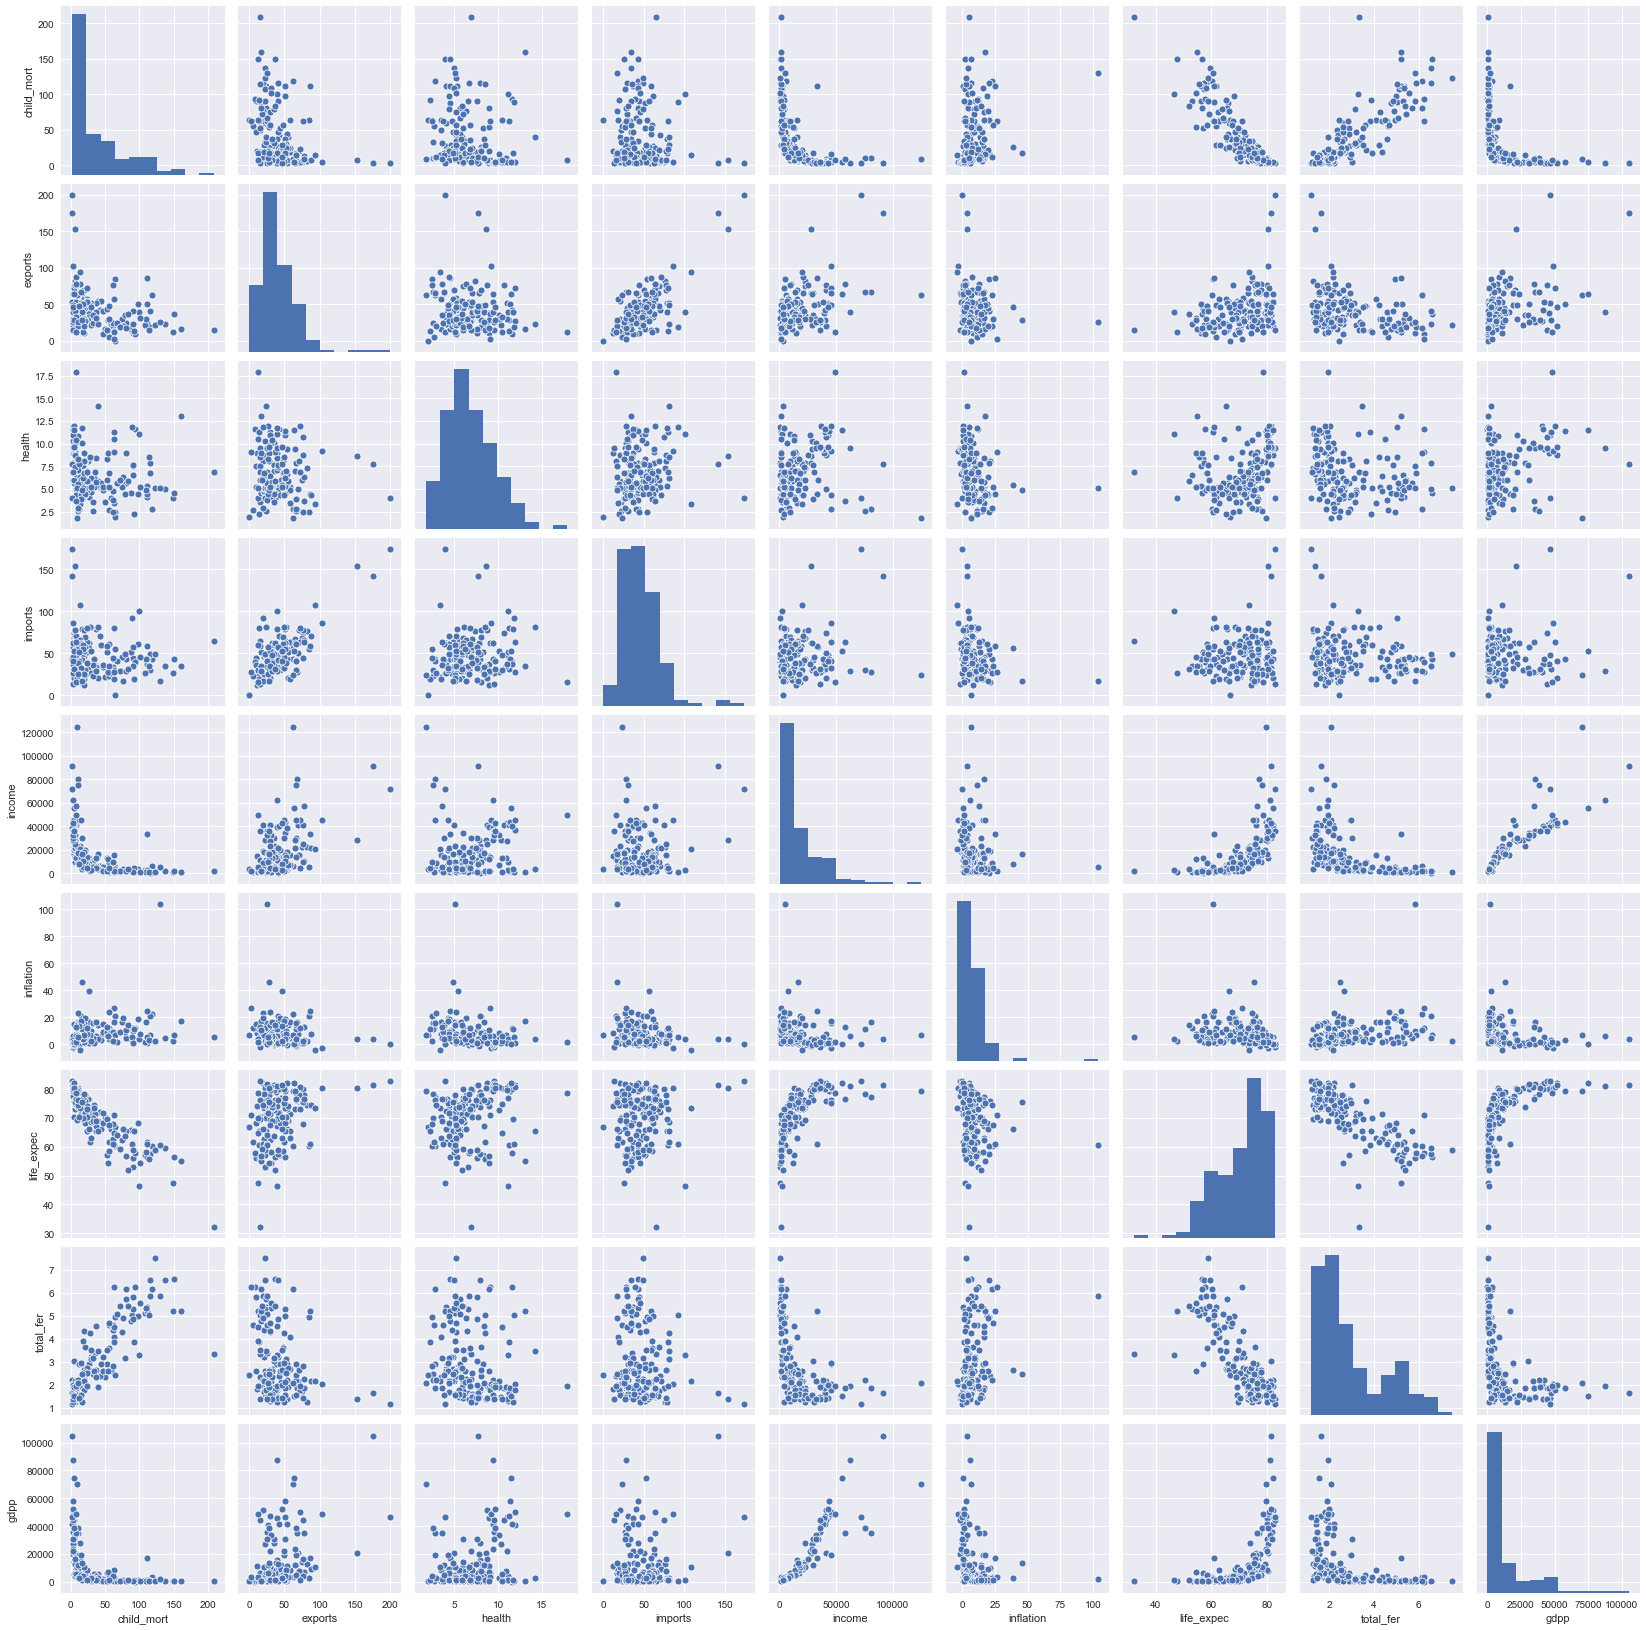

In [5]:
sns.pairplot(country.drop('country',axis=1))

In [6]:
country_cor = country.drop('country',axis=1).corr()
country_cor

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


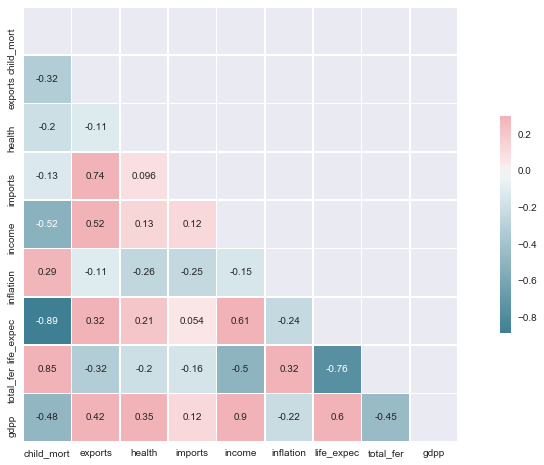

In [7]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(country_cor, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(country_cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

The heat map above shows that some of the variables are strongly correlated. For example:

- income and GDP per capita
- child mortality rate and life expectancy
- imports and exports

To address and minimize the extreme value issues, we need to perform some kind of scalling to the dataset. One of the most commen method is the `MinMaxScaler()`. We'll store the scalled dataset to a new dataframe called country_scale_df

In [8]:
# scale the data
min_max_scaler = MinMaxScaler()
country_scale = min_max_scaler.fit_transform(country.drop('country',axis=1))
country_scale_df = pd.DataFrame(data = country_scale,
                               columns=country.columns[1:])
country_scale_df['country'] = country['country']
country_scale_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Afghanistan
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Albania
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Algeria
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Angola
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Antigua and Barbuda


## Principal Component Analysis

**Pricipal Component Analysis (PCA)** is a Dimensionality Reduction technique usually used in large datasets with multiple dimensions, by transforming a large set of variables into a smaller one that still contains most of the information in the original dataset.

We start the PCA by starting an instance of it using `PCA()` and fit it with the scaled country data. The optimal number of Principal compenent are chosen by picking the minimum number of components that demonstrates the highest amount of variance.

After plotting the the cumulative summation of the **explained variance** with the **number of Principal components**, we can see that the optimal number of Principal Components are 5. Compared with the original dataset which have 9 dimensions, PCA have reduced the dimension to 5 and still able to explain over 95% of the variance of the dataset.

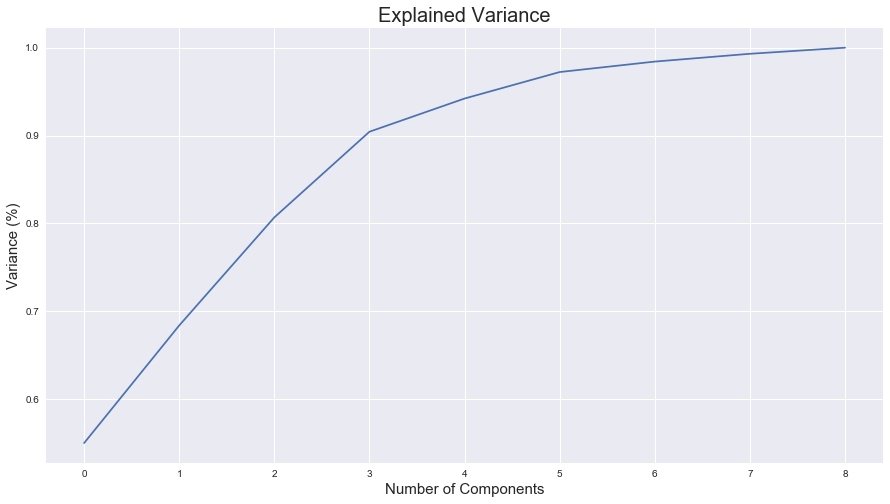

In [9]:
# pass through the scaled data set into our PCA class object
pca = PCA().fit(country_scale)

# plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# define the labels & title
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15) 
plt.title('Explained Variance', fontsize = 20)

# show the plot
plt.show()

We then use 5 as `n_component` parameter and save the PCA dataset into a new object called country_pca, this dataset will be used to preform the final clustering.

In [10]:
# we will choose 5 pca components and create a new dataset

country_pca = PCA(n_components=5).fit(country_scale).transform(country_scale)

# store it in a new data frame
country_pca= pd.DataFrame(data = country_pca, columns = ['principal component 1', 'principal component 2',
                                                        'principal component 3','principal component 4',
                                                        'principal component 5'])
# country_pca['country'] = country['country']

country_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-0.599078,0.095490,0.157554,-0.024333,-0.045618
1,0.158474,-0.212092,-0.064189,-0.061247,0.014191
2,0.003686,-0.135867,-0.134182,0.133574,-0.091150
3,-0.650235,0.275975,-0.142672,0.156018,-0.081997
4,0.200711,-0.064662,-0.100715,-0.037902,-0.035799


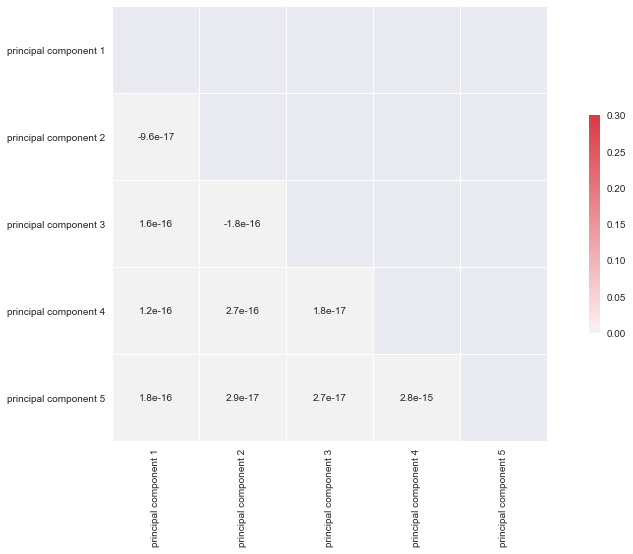

In [11]:
country_pca_cor = country_pca.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(country_pca_cor, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(country_pca_cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

## Kmeans Clustering

Kmeans clustering is one of the most commenly used clustering algorithm due to its easy inplementation. The only parameter we need to define for Kmeans clustering is the number of K.

There are many different methods to define the optimal number of k, the most commenly used one is called the elbow method. Below is how to read the elbow plot from geeksforgeeks.com.
![Elbow Method for defining the optimal K](https://media.geeksforgeeks.org/wp-content/uploads/20190606105550/distortion1.png)
>To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

The metric for sklearn Kmeans distortion/inertia is stored in `inertia_` variable and we'd like to try multiple k values to see how the inertia changes for different k value.

In [12]:
# define a dictionary that contains all of our relevant info.
results = []

# define how many clusters we want to test up to.
num_of_clusters = 10

# run through each instance of K
for k in range(2, num_of_clusters):
    
    print("-"*100)
    
    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state=0).fit(country_pca)
    
    
    # store the different metrics
#     results_dict_pca[k]['silhouette_score'] = sil_score
#     results_dict_pca[k]['inertia'] = kmeans.inertia_
#     results_dict_pca[k]['score'] = kmeans.score
#     results_dict_pca[k]['model'] = kmeans
    
    results.append(kmeans.inertia_)
    
    # print the results    
    print("Number of Clusters: {}".format(k),kmeans.inertia_)


----------------------------------------------------------------------------------------------------
Number of Clusters: 2 23.470576526054646
----------------------------------------------------------------------------------------------------
Number of Clusters: 3 16.883151711020606
----------------------------------------------------------------------------------------------------
Number of Clusters: 4 14.337590232281652
----------------------------------------------------------------------------------------------------
Number of Clusters: 5 12.601899387317541
----------------------------------------------------------------------------------------------------
Number of Clusters: 6 11.382314369663833
----------------------------------------------------------------------------------------------------
Number of Clusters: 7 10.532291426965784
----------------------------------------------------------------------------------------------------
Number of Clusters: 8 9.169882734609471
-------

Then we plot the Elbow Method for optimal k, we can see that the optimal k value will be 3.

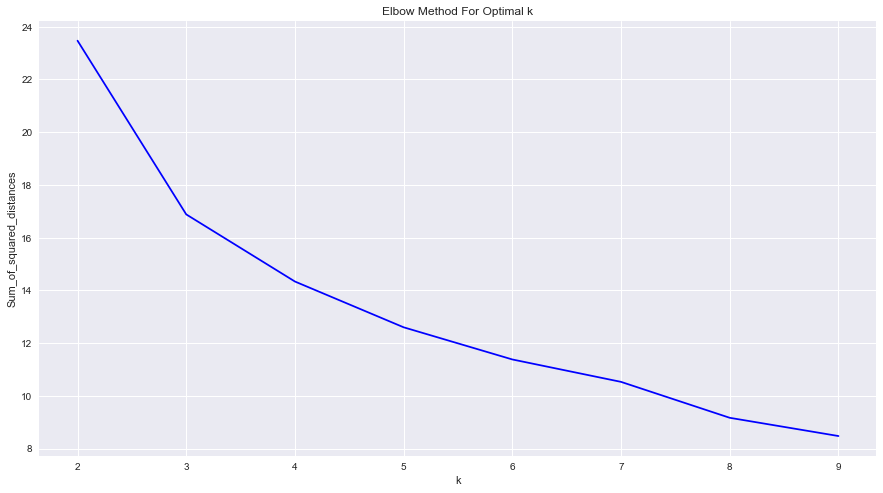

In [13]:
plt.plot(range(2, num_of_clusters), results, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Another good way to determine the optimal k is called Silhouette analysis, It can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like the number of clusters visually. This measure has a range of (-1, 1).

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

With the help of `yellowbrick` package, we can use `SilhouetteVisualizer()` to visualized the Silhouette score for different k. What we are looking for is that each cluster exceeds the red line or the average silhouette score and that the clusters are as evenly distributed as possible. We are only going to focus on k = 2, k = 3 and k = 4 since based on the elbow method, these are the possible choices.

We can see that although for all k, each cluster are above the red line, but only when k = 3 provides a more evenly distributed cluters, so both methods indicate that we should choose k = 3 for out Kmeans clustering.

----------------------------------------------------------------------------------------------------


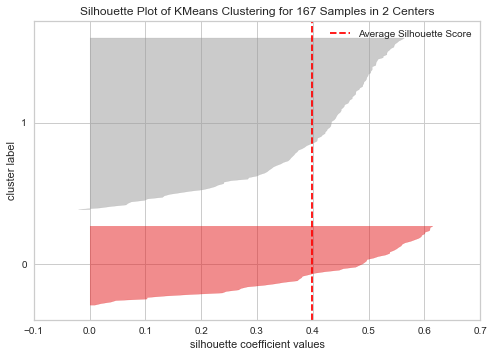

----------------------------------------------------------------------------------------------------


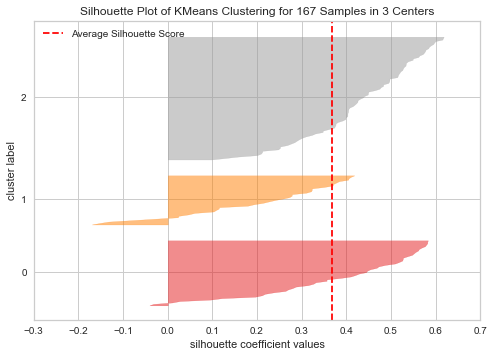

----------------------------------------------------------------------------------------------------


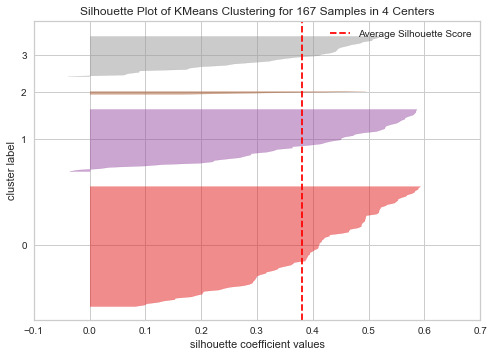

In [14]:
# From the graph above, it indicates that we should choose k = 3

from yellowbrick.cluster import SilhouetteVisualizer

clusters = [2,3,4]

for cluster in clusters:
    
    print('-'*100)

    # define the model for K
    kmeans = KMeans(n_clusters = cluster, random_state=0)

    # pass the model through the visualizer
    visualizer = SilhouetteVisualizer(kmeans)

    # fit the data
    visualizer.fit(country_pca)

    # show the chart
    visualizer.poof()

    
# the silhouette plot also shows that the optimal k is 3

The last step is to apply the kmeans clustering to the data and get the lables of which cluster each country falls into.

In [15]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(country_pca)
country['cluster'] = kmeans.labels_
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


Print out the country in each cluster

**Cluster 1**

In [16]:
country[country['cluster'] == 0][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,0
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,0
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334,0


**Cluster 2**

In [17]:
country[country['cluster'] == 1][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,1
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,1
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,1
42,Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,1
43,Czech Republic,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800,1
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1
54,France,4.2,26.8,11.90,28.1,36900,1.050,81.4,2.03,40600,1


**Cluster 3**

In [18]:
country[country['cluster'] == 2][:10]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,2
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,2
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,2
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,2
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,2
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,2
12,Bangladesh,49.4,16.0,3.52,21.8,2440,7.140,70.4,2.33,758,2
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,2


By looking at the output of the countries in each cluster, combined with our knowledge on some of the countries. We can see that:

- **Cluster 1** are those less developed countries, most of which are in Africa
- **Cluster 2** are those developed countries, most of which are in Europe, North America and some part of Asia
- **Cluster 3** are thoe developing countries, most of whic are in South America and Asia